In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandahouse as ph
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.tsa.seasonal import STL
import seaborn as sns

In [3]:
# set the connection with the db

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230720',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

### Task 1  
Проводить исследования и интерпретировать их результаты - одна из главных задач аналитика, но для правильной постановки гипотезы нужно понимать, что происходит в данных.

Этим мы и займёмся - давайте познакомимся с нашими данными чуть ближе, чем названия колонок и их содержание! Первое, что мы можем сделать - это посчитать описательные статистики по лайкам и просмотрам в группировке по постам.

Укажите, что из этого НЕ ХАРАКТЕРНО для наших данных. Возможно, вы догадаетесь о правильном ответе даже без описательных статистик :)  

По мерам центральной тенденции просмотры опережают лайки  
Самые популярные посты собирают миллионы просмотров  
Медиана лайков приблизительно такая же, как и среднее по ним же

In [4]:
# create a query - group by posts, count likes and views,
# show life_time of the post

query = '''
select post_id,
count(action) filter (where action = 'view') views, 
count(action) filter (where action = 'like') likes,
dateDiff('day', min(time), max(time)) life_time_days
from {db}.feed_actions
group by post_id
order by views DESC, likes DESC
'''

# import a table to a dataframe

df = ph.read_clickhouse(query, connection=connection)
df.head()

,post_id,views,likes,life_time_days
0,3129,95802,28148,6
1,2936,92111,25474,8
2,3120,83915,23786,6
3,2871,78501,21113,8
4,2813,77032,21234,8


In [4]:
# create a query - group by posts, count likes and views,
# show life_time of the post

query = '''
select post_id,
count(action) filter (where action = 'view') views, 
count(action) filter (where action = 'like') likes,
dateDiff('day', min(time), max(time)) life_time_days
from {db}.feed_actions
group by post_id
order by views DESC, likes DESC
'''

# import a table to a dataframe

df = ph.read_clickhouse(query, connection=connection)
df.head()

,post_id,views,likes,life_time_days
0,2936,87506,24540,7
1,3129,85276,25829,5
2,2871,78355,21087,8
3,2813,77032,21234,8
4,3120,75346,21972,5


In [5]:
df.iloc[:, 1:].describe() # descript. stat. for likes, views, and lifetimes

,views,likes,life_time_days
count,3328.000000,3328.000000,3328.000000
mean,5968.600060,1254.679988,1.913161
std,9658.429482,2506.393362,1.404821
min,1.000000,0.000000,0.000000
25%,428.000000,38.000000,1.000000
50%,2204.000000,288.000000,2.000000
75%,7087.750000,1252.500000,3.000000
max,87506.000000,25829.000000,8.000000


По мерам центральной тенденции просмотры опережают лайки - true  
Самые популярные посты собирают миллионы просмотров - false  
Медиана лайков приблизительно такая же, как и среднее по ним же - false, there are outliers

### Task 2  
Описательные статистики - это, конечно, хорошо. Но визуализация данных гораздо нагляднее!

Нарисуйте распределения просмотров и лайков по постам. Какая у них форма и есть ли различия в этой форме? Выберите правильные варианты.

NB! Вам может помочь сравнение квантилей двух распределений через QQ-график. Перед этим их стоит z-стандартизовать, чтобы привести к общей шкале. Для большей наглядности советуем указать аргумент line="45". Отклонения от линии будут означать разницу в распределениях!

In [6]:
# Let`s create the z-transformed views and likes columns -
# easier to compare distributions with a QQ-plot:

views = df.loc[:, 'views']
likes = df.loc[:, 'likes']

df.loc[:, 'views_z'] = ( views - views.mean() ) / views.std()
df.loc[:, 'likes_z'] = ( likes - likes.mean() ) / likes.std()

df.describe()

,post_id,views,likes,life_time_days,views_z,likes_z
count,3328.000000,3328.000000,3328.000000,3328.000000,3.328000e+03,3.328000e+03
mean,1740.790865,5968.600060,1254.679988,1.913161,-1.024821e-16,-6.832142e-17
std,1002.525157,9658.429482,2506.393362,1.404821,1.000000e+00,1.000000e+00
min,0.000000,1.000000,0.000000,0.000000,-6.178644e-01,-5.005918e-01
25%,870.750000,428.000000,38.000000,1.000000,-5.736543e-01,-4.854306e-01
50%,1748.500000,2204.000000,288.000000,2.000000,-3.897735e-01,-3.856857e-01
75%,2613.250000,7087.750000,1252.500000,3.000000,1.158729e-01,-8.697709e-04
max,3458.000000,87506.000000,25829.000000,8.000000,8.442097e+00,9.804654e+00


In [7]:
# to each row of views, add a label showing its quartile

df['views_quartile'] = pd.qcut(df['views'], q=4, labels=False)
df.head()

,post_id,views,likes,life_time_days,views_z,likes_z,views_quartile
0,2936,87506,24540,7,8.442097,9.290369,3
1,3129,85276,25829,5,8.211211,9.804654,3
2,2871,78355,21087,8,7.494635,7.912693,3
3,2813,77032,21234,8,7.357656,7.971343,3
4,3120,75346,21972,5,7.183093,8.265790,3


In [12]:
# let`s look at the distribution of views, likes, their box-plots, 
# QQ-plot of views vs likes, and scatter of views vs likes

def compare_two_distr(data, distr1, distr2, label1=None, label2=None, hue=None):
    
    if (not label1) or (not label2):
        label1, label2 = distr1.name, distr2.name
    
    fig, axs = plt.subplots(2, 3, figsize=(20, 16)) # canvas creation and sizing
    fig.subplots_adjust(hspace=0.5, wspace=0.3)   

    sns.histplot(distr1, ax=axs[0, 0]) # 1st distribution
    axs[0, 0].set_xlim(-1, 4)
    axs[0, 0].set_title(f'distribution of {label1}')

    sns.histplot(distr2, ax=axs[1, 0]) # 2nd distribution
    axs[1, 0].set_xlim(-1, 5)
    axs[1, 0].set_title(f'distribution of {label2}')

    sns.boxplot(data=distr1, ax=axs[0, 1])
    axs[0, 1].set_title(f'{label1}')

    sns.boxplot(data=distr2, ax=axs[1, 1])
    axs[1, 1].set_title(f'{label2}')

    qqplot_2samples(
        distr1, 
        distr2, 
        xlabel=f'quantiles of {label1}',
        ylabel=f'quantiles of {label2}',
        ax=axs[0, 2], 
        line='45') # Create the QQ-plot
    axs[0, 2].set_title(f'qq: {label1} vs {label2}')

    if data is not None:
        sns.scatterplot(
            data=data, 
            x=f'{label1}', 
            y=f'{label2}', 
            hue=hue, 
            palette=['red', 'green', 'blue', 'magenta'], 
            ax=axs[1, 2]
        ) # create the scatter

        axs[1, 2].set_xlim(-.75, 2)
        axs[1, 2].set_ylim(-.75, 2)
        silence = axs[1, 2].set_title(f'{label1} vs {label2}')           


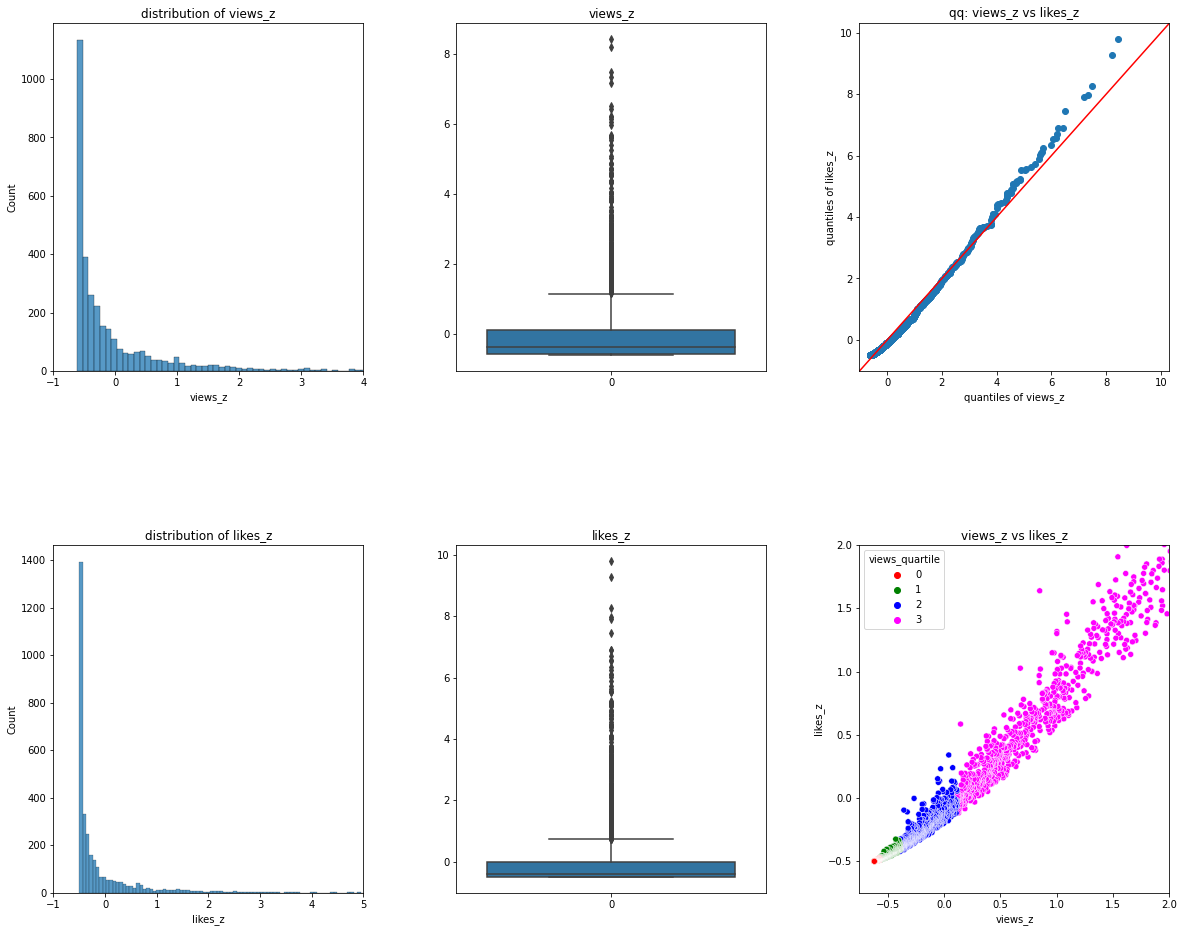

In [15]:
compare_two_distr(df, df.views_z, df.likes_z, hue='views_quartile')

The two metrics are exponentially distributed;  
At the top quantiles, we can see that likes are more represented relative to views than in lower quantiles;  
No clear subgroups;  
The metrics are peaking at low values (around -.5 in z-scale) - a lot of 'grey' posts with almost zero views.  

Now to the CTR (likes / views for a post) and post lifetime (time_last_action - time_first_action) vizualization.  


### Task 3  
"Сырые" лайки и просмотры могут быть познавательными сами по себе, но качество поста можно оценить не только по ним. Полезной может оказаться такая метрика как CTR - в данном случае это отношение количества лайков ко всем просмотрам данного поста. Также важную информацию может дать время существования поста - насколько продолжительное время конкретный пост смотрят и лайкают.

Посчитайте CTR и время существования для каждого из постов (от первого просмотра поста). Затем:

    Нарисуйте их распределения
    Постройте корреляционную матрицу между ними, просмотрами и лайками
    Визуализируйте все эти взаимосвязи в виде диаграмм рассеяния

In [16]:
df.loc[:, 'ctr'] = likes / views # likes and views variables are aliases for the columns of our df

df.head()

,post_id,views,likes,life_time_days,views_z,likes_z,views_quartile,ctr
0,2936,87506,24540,7,8.442097,9.290369,3,0.280438
1,3129,85276,25829,5,8.211211,9.804654,3,0.302887
2,2871,78355,21087,8,7.494635,7.912693,3,0.269121
3,2813,77032,21234,8,7.357656,7.971343,3,0.275652
4,3120,75346,21972,5,7.183093,8.265790,3,0.291615


In [17]:
df_filtered = df.loc[:, df.columns.isin(
    [
 'life_time_days',
 'views_z',
 'likes_z',
 'ctr'
    ]
)
] # leave only the columns we`d like to compare
df_filtered.head()

,life_time_days,views_z,likes_z,ctr
0,7,8.442097,9.290369,0.280438
1,5,8.211211,9.804654,0.302887
2,8,7.494635,7.912693,0.269121
3,8,7.357656,7.971343,0.275652
4,5,7.183093,8.265790,0.291615


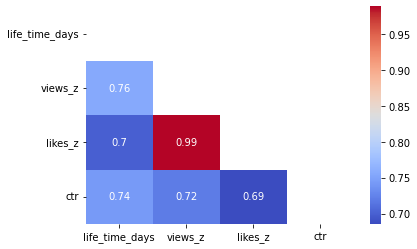

In [18]:
# Create a correlation matrix for the filtered series and plot a heatmap
corr_matrix = df_filtered.corr()

# Create a mask (matrix with bool values) to hide the upper diagonal part of the matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot a correlation heatmap with masked upper diagonal
silence = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask)

In [19]:
mask # see how the mask looks for a heatmap

array([[ True,  True,  True,  True],
       [False,  True,  True,  True],
       [False, False,  True,  True],
       [False, False, False,  True]])

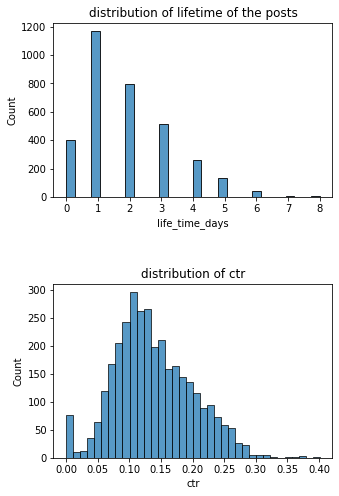

In [20]:
# let`s plot distributions of lifetime and ctr and look and the scatter matrix

fig, axs = plt.subplots(2, 1, figsize=(5, 8)) # canvas creation
fig.subplots_adjust(hspace=0.5, wspace=0.3)   

sns.histplot(df_filtered.life_time_days, ax=axs[0])
axs[0].set_title('distribution of lifetime of the posts')

sns.histplot(df_filtered.ctr, ax=axs[1])
silence = axs[1].set_title('distribution of ctr')



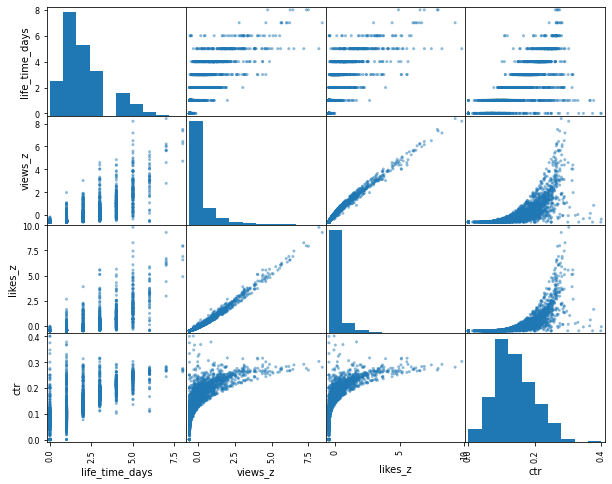

In [21]:
silence = pd.plotting.scatter_matrix(df_filtered, figsize=(10, 8))

В среднем посты "живут" пять дней = false, mean at ca 1-3 d  
Между количеством лайков и временем существования поста связь линейная = false  
По сравнению с просмотрами и лайками CTR менее асимметричен  = true  
Сильнее всего коррелируют CTR и время существования поста = false

linear correlation is only for likes vs views.  
explonential pattern for ctr vs likes / ctr vs views.  
for lifetime, ctr, likes, views tends to be higher for higher values

### Task 4
Всё это время мы оценивали наши данные "в статике". Давайте теперь обратимся к их динамике! Попробуем определить, что вообще приводит к изменениям в наших метриках - в самом первом приближении.

Нарисуйте дневную динамику активности уникальных пользователей, а затем просмотра уникальных постов. 

In [22]:
# lets group the data by days (e.g. 2020-05-07), 
# and count unique users and views of unique posts
# (how many unique users visited the platform
# and how many unique posts are viewed within that day)

# lets do a query first:

query = '''
with unique_users_posts as
(select toStartOfDay(time) as day
, count(DISTINCT user_id)  as counted_users
, count(DISTINCT post_id) filter (where action = 'view') as counted_posts
from simulator_20230720.feed_actions 
group by day
order by day desc
)

select day
, counted_users * 100 / (select sum(counted_users) from unique_users_posts) users_norm
, counted_posts * 100 / (select sum(counted_posts) from unique_users_posts) posts_norm
from unique_users_posts
'''

# import a table to a dataframe

df_daily = ph.read_clickhouse(query, connection=connection)
df_daily.head()

,day,users_norm,posts_norm
0,2023-07-19,1.574331,2.189251
1,2023-07-18,3.192669,2.998547
2,2023-07-17,3.167855,2.925918
3,2023-07-16,3.075966,2.905167
4,2023-07-15,3.009860,2.500519


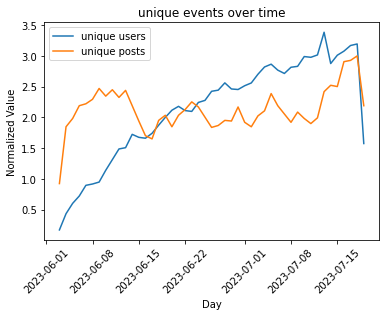

In [23]:
# now plot two lines to see trends:

# fig, axs = plt.subplots(2, 1, figsize=(5, 8)) # canvas creation
# fig.subplots_adjust(hspace=0.5, wspace=0.3) 

sns.lineplot(data=df_daily, x='day', y='users_norm', label='unique users')
sns.lineplot(data=df_daily, x='day', y='posts_norm', label='unique posts')

plt.ylabel('Normalized Value')
plt.xlabel('Day')
plt.title('unique events over time')
# Rotate x-axis ticks by 45 degrees
silence = plt.xticks(rotation=45)



### Task 5
Мы посмотрели как на вклад пользователей, так и вклад постов в общую динамику просмотров и лайков. Однако не менее полезной может оказаться декомпозиция временного ряда на компоненты - чтобы выделить отдельные составляющие части процесса.

Возьмите почасовую динамику активности за весь период и проанализируйте её этой функцией: https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html



In [24]:
# lets get the data grouped by hours first:

query = '''
WITH unique_users_posts AS
(SELECT 
dateDiff('hour', (SELECT min(toStartOfHour(time)) FROM simulator_20230720.feed_actions), toStartOfHour(time)) AS hour
, COUNT(DISTINCT user_id)  AS counted_users
, COUNT(DISTINCT post_id) FILTER (WHERE action = 'view') AS counted_posts
FROM simulator_20230720.feed_actions 
GROUP BY hour
ORDER BY hour DESC
)

SELECT hour
, counted_users * 100 / (select sum(counted_users) from unique_users_posts) AS users_norm
, counted_posts * 100 / (select sum(counted_posts) from unique_users_posts) AS posts_norm
FROM unique_users_posts
'''

# import a table to a dataframe

df_hourly = ph.read_clickhouse(query, connection=connection)
df_hourly.head()

,hour,users_norm,posts_norm
0,1114,0.015849,0.132195
1,1113,0.153641,0.141057
2,1112,0.135800,0.141057
3,1111,0.112762,0.145488
4,1110,0.094575,0.145488


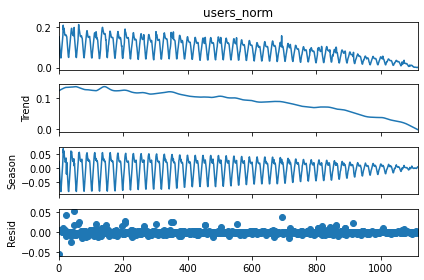

In [25]:
# lets apply the function to the views, set period to 24 (hours):

res = STL(df_hourly['users_norm'], period=24).fit()
res.plot()
plt.show()

### Task 6
Вы могли заметить из прошлого задания, что просмотры постов "колеблются" в течение дня. Вопрос: а отличается ли распределение дневной активности пользователей от распределения публикации постов? В качестве прокси времени публикации возьмите время первого просмотра поста.

Визуализируйте оба распределения для каждого часа дня.

In [26]:
# the table we would need: hour (0-23) - count_users - count_published_posts
# table 1: post_id - hour_of_publishing. Before the join, group by hour and count posts.
# table 2: hour - count_unique_users

query = '''
WITH unique_users_posts AS
(SELECT 
toStartOfHour(time) AS hour
, COUNT(DISTINCT user_id)  AS counted_users
, COUNT(DISTINCT post_id) FILTER (WHERE action = 'view') AS counted_posts
FROM simulator_20230720.feed_actions 
GROUP BY hour
ORDER BY hour DESC
)

SELECT hour, users_count, posts_count
FROM
(SELECT toHour(hour) AS hour, SUM(counted_users) AS users_count
FROM unique_users_posts
GROUP BY hour
) AS uniqiue_users_hourly
LEFT JOIN
(SELECT hour, count(post_id) AS posts_count  FROM 
(SELECT toHour(min(time)) AS hour, post_id
FROM simulator_20230720.feed_actions
GROUP BY post_id
ORDER BY hour) AS hour_of_posting
GROUP BY hour
) AS posting_by_hour
ON uniqiue_users_hourly.hour = posting_by_hour.hour

'''

# import a table to a dataframe

df_posting_activity = ph.read_clickhouse(query, connection=connection)
df_posting_activity.head()

,hour,users_count,posts_count
0,0,38091,163
1,1,31406,37
2,2,24798,5
3,3,18032,0
4,4,18828,0


In [32]:
# now lets normalize each series to plot them on the same plot

users_count = df_posting_activity.loc[:, 'users_count']
posts_count = df_posting_activity.loc[:, 'posts_count']

df_posting_activity.loc[:, 'users_count_norm'] = users_count / users_count.sum()
df_posting_activity.loc[:, 'posts_count_norm'] = posts_count / posts_count.sum()

df_posting_activity.head()

,hour,users_count,posts_count,users_count_z,posts_count_z,users_count_norm,posts_count_norm
0,0,38091,163,-0.646550,0.141747,0.032989,0.048978
1,1,31406,37,-1.077913,-0.592232,0.027199,0.011118
2,2,24798,5,-1.504307,-0.778640,0.021476,0.001502
3,3,18032,0,-1.940897,-0.807766,0.015617,0.000000
4,4,18828,0,-1.889533,-0.807766,0.016306,0.000000


/tmp/ipykernel_132/193853621.py:36: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


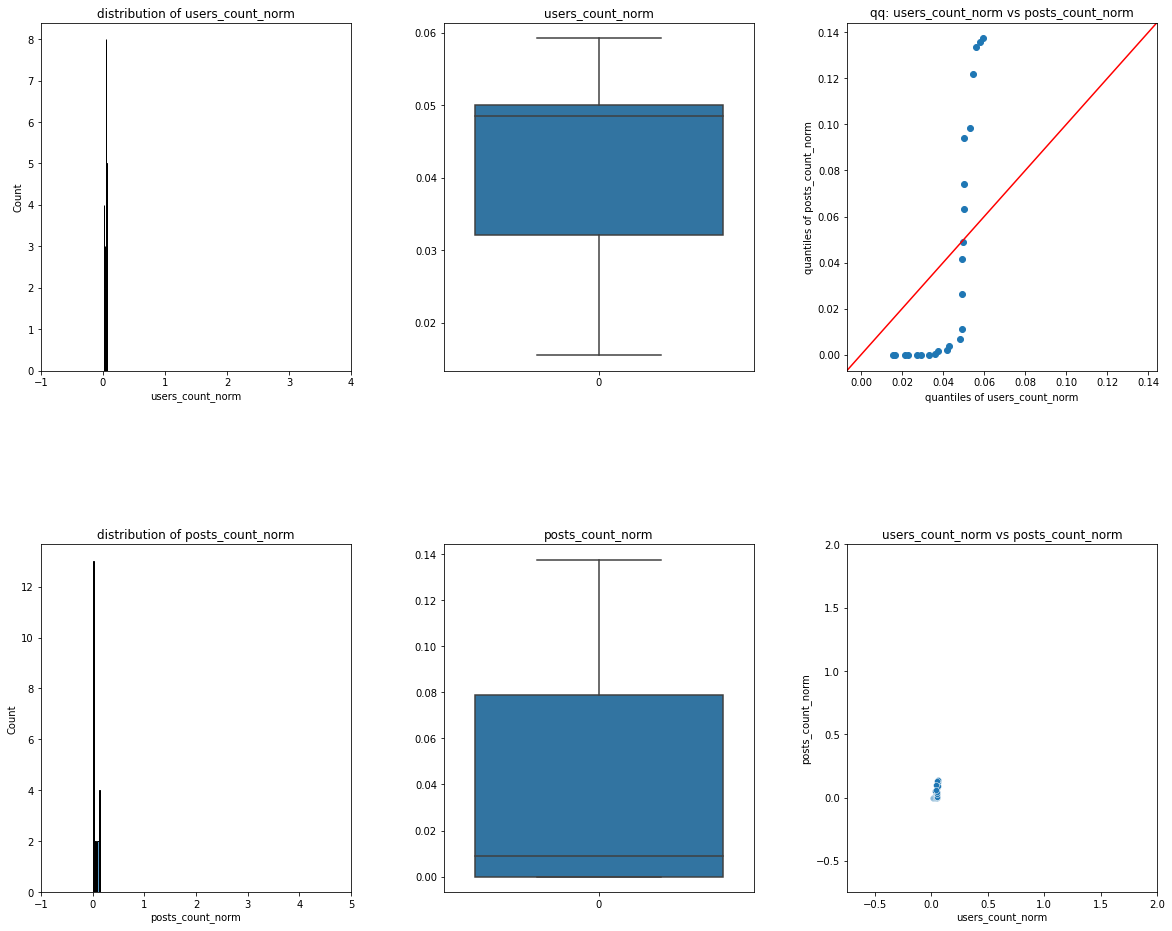

In [31]:
# let`s look at the distribution of users_count, posts_count 
# QQ-plot of users_count vs posts_count, and scatter of users_count vs posts_count

compare_two_distr(df_posting_activity, df_posting_activity.users_count_norm, df_posting_activity.posts_count_norm)

In [1]:
sns.barplot(data=df_posting_activity, x='hour', y='users_count_norm')

NameError: name 'sns' is not defined

<Axes: xlabel='hour', ylabel='posts_count_norm'>

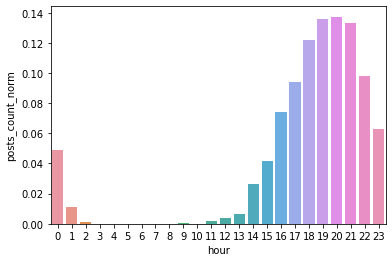

In [36]:
sns.barplot(data=df_posting_activity, x='hour', y='posts_count_norm')

In [ ]:
sns.lineplot